In [1]:
import wntr

# Caricare il modello da un file .inp
wn = wntr.network.WaterNetworkModel(r'C:\Users\nephr\Desktop\Uni Nuova\Tesi\WNTR-main\WNTR-main\examples\networks\Net3.inp')


In [2]:
# Informazioni generali sulla rete
print(wn.describe())

# Lista nodi e link
print("Nodi:", wn.node_name_list)
print("Link:", wn.link_name_list)

# Contare quanti elementi
print("Numero nodi:", wn.num_nodes)
print("Numero condotte:", wn.num_pipes)


{'Nodes': 97, 'Links': 119, 'Patterns': 5, 'Curves': 2, 'Sources': 0, 'Controls': 18}
Nodi: ['10', '15', '20', '35', '40', '50', '60', '601', '61', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119', '120', '121', '123', '125', '127', '129', '131', '139', '141', '143', '145', '147', '149', '151', '153', '157', '159', '161', '163', '164', '166', '167', '169', '171', '173', '177', '179', '181', '183', '184', '185', '187', '189', '191', '193', '195', '197', '199', '201', '203', '204', '205', '206', '207', '208', '209', '211', '213', '215', '217', '219', '225', '229', '231', '237', '239', '241', '243', '247', '249', '251', '253', '255', '257', '259', '261', '263', '265', '267', '269', '271', '273', '275', 'River', 'Lake', '1', '2', '3']
Link: ['20', '40', '50', '60', '101', '103', '105', '107', '109', '111', '112', '113', '114', '115', '116', '117', '119', '120', '121', '122', '123', '125', '129', '131', '133', '135', '137', '145', '147', '149', '151', '153', '155', '159'

In [3]:
# Eseguire una simulazione idraulica (solver integrato WNTRSimulator)
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

# Ottenere la pressione nei nodi
pressure = results.node['pressure']
print(pressure.head())

# Ottenere la portata nelle tubazioni
flowrate = results.link['flowrate']
print(flowrate.head())


              10         15         20         35        40        50  \
0      -0.450073  28.593627   8.839205  40.612469  3.992880  7.162800   
3600   28.253711  28.887127   9.099182  41.513749  4.191189  6.752903   
7200   28.764331  30.003203   9.450788  42.429091  4.620535  6.369759   
10800  28.871435  30.415546   9.869710  42.817159  5.158938  6.534979   
14400  29.659301  31.970718  10.284735  44.297865  5.665952  6.740015   

              60        601         61        101  ...        267        269  \
0      63.706435  92.187892  92.187892  31.553927  ...  38.151548  44.650843   
3600   63.751481  92.490337  92.490337  39.867815  ...  39.722347  45.767286   
7200   63.793484  92.773662  92.773662  41.517107  ...  40.730854  46.730696   
10800  63.813132  92.906626  92.906626  41.862691  ...  41.116520  47.115631   
14400  63.877903  93.346995  93.346995  44.400792  ...  42.755896  48.670089   

             271        273        275         1         2          3  River  \


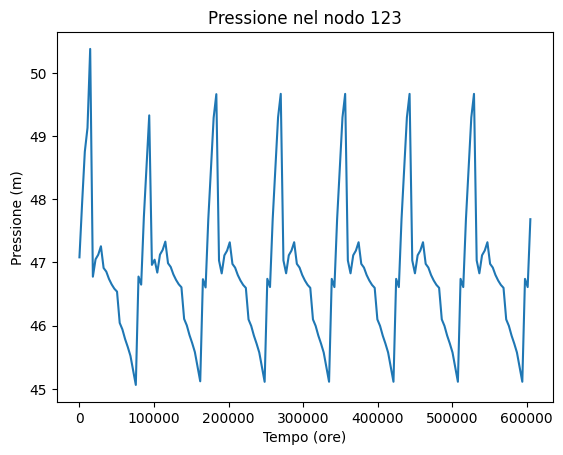

In [4]:
import matplotlib.pyplot as plt

# Pressione media di un nodo a scelta (es. '123')
node = '123'
pressure[node].plot()
plt.title(f'Pressione nel nodo {node}')
plt.xlabel('Tempo (ore)')
plt.ylabel('Pressione (m)')
plt.show()


# Inizio Vero

In [4]:
!pip install wntr pandas networkx torch torch_geometric


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# -*- coding: utf-8 -*-
# loader_features.py
from pathlib import Path
from typing import Tuple
import numpy as np
import pandas as pd
import networkx as nx
import wntr

def _safe_float(x, default=None):
    try:
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return default
        return float(x)
    except Exception:
        return default

def load_wdn(inp_path: str, use_length_as_weight: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame, nx.Graph]:
    """
    Carica il .inp WNTR e costruisce:
      - nodes_df: feature base per nodo (elevation, base_demand, coords, node_type)
      - links_df: feature base per arco (from,to,length,diameter,roughness,status,link_type)
      - G: grafo NetworkX non orientato con 'weight' (di default = length)
    """
    p = Path(inp_path)
    if not p.exists():
        raise FileNotFoundError(f"File .inp non trovato: {inp_path}")

    wn = wntr.network.WaterNetworkModel(inp_path)

    all_nodes = pd.Index(wn.node_name_list, name="node_name")
    def q_node(attr: str) -> pd.Series:
        return wn.query_node_attribute(attr).reindex(all_nodes)

    elev_s      = q_node('elevation')
    coords_s    = q_node('coordinates')
    base_dem_s  = q_node('base_demand')
    node_type_s = pd.Series({n: wn.get_node(n).node_type for n in all_nodes},
                            index=all_nodes, name="node_type")

    x_s = coords_s.apply(lambda v: v[0] if isinstance(v, tuple) and len(v)==2 else np.nan)
    y_s = coords_s.apply(lambda v: v[1] if isinstance(v, tuple) and len(v)==2 else np.nan)

    nodes_df = pd.DataFrame({
        'node_type': node_type_s,
        'elevation_m': elev_s,
        'base_demand_m3s': base_dem_s,
        'x': x_s,
        'y': y_s
    }, index=all_nodes)

    length_s = wn.query_link_attribute('length')
    diam_s   = wn.query_link_attribute('diameter')
    rough_s  = wn.query_link_attribute('roughness')
    status_s = wn.query_link_attribute('status')

    rows = []
    for lname in wn.link_name_list:
        L = wn.get_link(lname)
        rows.append({
            "link_name": lname,
            "link_type": L.link_type,                # Pipe/Pump/Valve
            "from_node": L.start_node_name,
            "to_node":   L.end_node_name,
            "length_m":  _safe_float(length_s.get(lname), np.nan),
            "diameter_m":_safe_float(diam_s.get(lname),   np.nan),
            "roughness": _safe_float(rough_s.get(lname),  np.nan),
            "status":    status_s.get(lname)
        })
    links_df = pd.DataFrame(rows).set_index("link_name")

    # Costruisci grafo
    G = nx.Graph()
    G.add_nodes_from(all_nodes)
    for r in links_df.reset_index().itertuples(index=False):
        w = _safe_float(r.length_m, 1.0) if use_length_as_weight else 1.0
        G.add_edge(r.from_node, r.to_node,
                   link_name=r.link_name,
                   link_type=r.link_type,
                   length_m=_safe_float(r.length_m, None),
                   diameter_m=_safe_float(r.diameter_m, None),
                   roughness=_safe_float(r.roughness, None),
                   status=r.status,
                   weight=w)
    return nodes_df, links_df, G


In [6]:
# -*- coding: utf-8 -*-
# graph_metrics.py
from typing import Dict, Tuple
import json
import numpy as np
import pandas as pd
import networkx as nx

def compute_node_edge_metrics(
    nodes_df: pd.DataFrame,
    links_df: pd.DataFrame,
    G: nx.Graph,
    use_length_as_weight: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Aggiunge metriche di NODO e di ARCO e calcola metriche GLOBALI.
    Ritorna: nodes_df_ext, links_df_ext, globals_dict
    """
    all_nodes = nodes_df.index

    weight_kw = {'weight': 'weight'} if use_length_as_weight else {}
    # Nodi
    deg_s      = pd.Series(dict(G.degree()), name='degree').reindex(all_nodes).fillna(0).astype(int)
    deg_cent_s = pd.Series(nx.degree_centrality(G), name='degree_centrality').reindex(all_nodes)
    btw_s      = pd.Series(nx.betweenness_centrality(G, normalized=True, **weight_kw),
                           name='betweenness_centrality').reindex(all_nodes)
    clo_s      = pd.Series(nx.closeness_centrality(G, distance=weight_kw.get('weight')),
                           name='closeness_centrality').reindex(all_nodes)
    clu_s      = pd.Series(nx.clustering(G), name='clustering_coeff').reindex(all_nodes)
    try:
        core_s = pd.Series(nx.core_number(G), name='core_number').reindex(all_nodes)
    except Exception:
        core_s = pd.Series(index=all_nodes, dtype=float, name='core_number')

    bridges = set(nx.bridges(G)) if G.number_of_edges() > 0 else set()
    bridge_count = {n: 0 for n in all_nodes}
    for u, v in bridges:
        bridge_count[u] += 1
        bridge_count[v] += 1
    bridge_cnt_s = pd.Series(bridge_count, name='bridge_count').reindex(all_nodes).fillna(0).astype(int)
    bridge_ratio = (bridge_cnt_s / deg_s.replace(0, np.nan)).rename('bridge_ratio')

    nodes_ext = pd.concat([nodes_df, deg_s, deg_cent_s, btw_s, clo_s, clu_s, core_s, bridge_cnt_s, bridge_ratio], axis=1)

    # Archi
    ebw = nx.edge_betweenness_centrality(G, normalized=True, **weight_kw) if G.number_of_edges() > 0 else {}
    edge_rows = []
    for r in links_df.reset_index().itertuples(index=False):
        uv = (r.from_node, r.to_node)
        eb = ebw.get(uv, ebw.get((uv[1], uv[0]), 0.0))
        is_bridge = (uv in bridges) or ((uv[1], uv[0]) in bridges)
        edge_rows.append({"link_name": r.link_name, "edge_betweenness": eb, "is_bridge": float(is_bridge)})
    edges_metrics_df = pd.DataFrame(edge_rows).set_index("link_name")
    links_ext = links_df.join(edges_metrics_df, how='left')

    # Globali
    globals_out = {}
    try:
        globals_out['assortativity'] = nx.degree_assortativity_coefficient(G)
    except Exception:
        globals_out['assortativity'] = None

    if nx.is_empty(G) or G.number_of_edges() == 0:
        C = L = None
    else:
        GC_nodes = max(nx.connected_components(G), key=len)
        GC = G.subgraph(GC_nodes).copy()
        C = nx.average_clustering(GC)
        try:
            L = nx.average_shortest_path_length(GC, weight=weight_kw.get('weight'))
        except Exception:
            L = None
    globals_out['avg_clustering_C'] = C
    globals_out['avg_path_length_L'] = L

    try:
        from networkx.algorithms.smallworld import sigma as nx_sigma, omega as nx_omega
        globals_out['small_world_sigma'] = nx_sigma(G, niter=10, nrand=10, seed=42)
        globals_out['small_world_omega'] = nx_omega(G, niter=10, nrand=10, seed=42)
        globals_out['C_rand'] = None
        globals_out['L_rand'] = None
    except Exception:
        globals_out.update({'C_rand': None, 'L_rand': None, 'small_world_sigma': None, 'small_world_omega': None})

    return nodes_ext, links_ext, globals_out

def save_globals(path_json: str, globals_dict: Dict):
    with open(path_json, "w", encoding="utf-8") as f:
        json.dump(globals_dict, f, indent=2)


In [7]:
# -*- coding: utf-8 -*-
# build_pyg_data.py
from typing import Dict, List, Tuple
import json
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data

STATUS_OPEN_VALUES = {"Open", 1, "OPEN", "open", True}

def one_hot(series: pd.Series, categories: List[str], prefix: str) -> pd.DataFrame:
    out = {}
    for cat in categories:
        out[f"{prefix}_{cat}"] = (series == cat).astype(float)
    return pd.DataFrame(out, index=series.index)

def zscore(df: pd.DataFrame, cols: List[str]):
    stats = {}
    df = df.copy()
    for c in cols:
        m = df[c].astype(float).mean(skipna=True)
        s = df[c].astype(float).std(skipna=True)
        s = float(s) if s and s > 0 else 1.0
        stats[c] = {"mean": float(m), "std": float(s)}
        df[c] = (df[c].astype(float) - m) / s
        df[c] = df[c].fillna(0.0)
    return df, stats

def build_pyg_tensors(
    nodes_df: pd.DataFrame,
    links_df: pd.DataFrame,
    node_type_cats: List[str] = None,
    link_type_cats: List[str] = None,
) -> Tuple[Data, Dict]:
    """
    Converte nodes_df + links_df in PyG Data (x, edge_index, edge_attr) + metadata (mapping, scaler, ordini feature).
    """
    if node_type_cats is None:
        node_type_cats = ["Junction", "Reservoir", "Tank"]
    if link_type_cats is None:
        link_type_cats = ["Pipe", "Pump", "Valve"]

    # One-hot
    node_type_oh = one_hot(nodes_df["node_type"], node_type_cats, prefix="nodeType")
    link_type_oh = one_hot(links_df["link_type"], link_type_cats, prefix="linkType")
    status_oh = pd.DataFrame({
        "status_open": links_df["status"].apply(lambda s: 1.0 if s in STATUS_OPEN_VALUES else 0.0),
    }, index=links_df.index)

    # Numeriche
    node_num_cols = [
        "elevation_m", "base_demand_m3s", "x", "y",
        "degree", "degree_centrality", "betweenness_centrality",
        "closeness_centrality", "clustering_coeff", "core_number",
        "bridge_count", "bridge_ratio"
    ]
    edge_num_cols = [
        "length_m", "diameter_m", "roughness", "edge_betweenness", "is_bridge"
    ]

    nodes_num_norm, node_stats = zscore(nodes_df, node_num_cols)
    edges_num_norm, edge_stats = zscore(links_df, edge_num_cols)

    X_nodes = pd.concat([nodes_num_norm[node_num_cols], node_type_oh], axis=1).fillna(0.0)
    X_edges = pd.concat([edges_num_norm[edge_num_cols], link_type_oh, status_oh], axis=1).fillna(0.0)

    # Mapping
    all_nodes = list(nodes_df.index)
    node2idx = {n: i for i, n in enumerate(all_nodes)}
    idx2node = {i: n for n, i in node2idx.items()}

    # edge_index (non orientato -> due direzioni)
    edge_index_list = []
    for r in links_df.reset_index().itertuples(index=False):
        u = node2idx[r.from_node]
        v = node2idx[r.to_node]
        edge_index_list.append([u, v])
        edge_index_list.append([v, u])
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T  # [2, 2E]

    # edge_attr (duplicato)
    edge_attr_src = torch.tensor(X_edges.values, dtype=torch.float32)  # [E, Fe]
    edge_attr = torch.vstack([edge_attr_src, edge_attr_src])          # [2E, Fe]

    x = torch.tensor(X_nodes.values, dtype=torch.float32)             # [N, Fv]

    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        num_nodes=x.shape[0]
    )

    meta = {
        "node2idx": node2idx,
        "idx2node": idx2node,
        "node_feat_order": list(X_nodes.columns),
        "edge_feat_order": list(X_edges.columns),
        "node_type_cats": node_type_cats,
        "link_type_cats": link_type_cats,
        "scalers": {"node_stats": node_stats, "edge_stats": edge_stats}
    }
    return data, meta

def save_artifacts(out_dir, data: Data, meta: Dict, globals_dict: Dict = None):
    import torch, json
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    torch.save(data, out_dir / "graph_data.pt")
    with open(out_dir / "meta.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2)
    if globals_dict is not None:
        with open(out_dir / "graph_globals.json", "w", encoding="utf-8") as f:
            json.dump(globals_dict, f, indent=2)


In [8]:
# -*- coding: utf-8 -*-
# models_dqn.py
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNEncoder(nn.Module):
    """
    GCN encoder che restituisce embeddings di nodo [N,H] e embedding globale [B,H] (mean pooling).
    """
    def __init__(self, in_channels: int, hidden: int = 128, out_channels: int = 128, num_layers: int = 3, dropout: float = 0.1):
        super().__init__()
        assert num_layers >= 1
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden, hidden))
        if num_layers > 1:
            self.convs.append(GCNConv(hidden, out_channels))
            self.out_dim = out_channels
        else:
            self.out_dim = hidden
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, data: Data):
        x, edge_index = data.x, data.edge_index
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = self.act(x)
                x = self.dropout(x)
        node_embeddings = x
        if hasattr(data, "batch") and data.batch is not None:
            g = global_mean_pool(node_embeddings, data.batch)
        else:
            g = node_embeddings.mean(dim=0, keepdim=True)
        return node_embeddings, g

class NodeActionDQNHead(nn.Module):
    """Q per azioni per-nodo (output [N, A])."""
    def __init__(self, emb_dim: int, action_dim_per_node: int = 1):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, action_dim_per_node)
        )
    def forward(self, node_embeddings: torch.Tensor) -> torch.Tensor:
        return self.ff(node_embeddings)

class GlobalActionDQNHead(nn.Module):
    """Q per azioni globali (output [B, n_actions])."""
    def __init__(self, emb_dim: int, n_actions: int):
        super().__init__()
        self.q = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, n_actions)
        )
    def forward(self, graph_emb: torch.Tensor) -> torch.Tensor:
        return self.q(graph_emb)


In [9]:
# -*- coding: utf-8 -*-
# action_space.py
from pathlib import Path
from typing import Dict, List, Tuple
import json
import numpy as np
import pandas as pd

# Un "open" generoso per gli status che arrivano da WNTR
STATUS_OPEN_VALUES = {"Open", 1, "OPEN", "open", True}

def _is_open(x) -> bool:
    return x in STATUS_OPEN_VALUES

def _adjacent_links(links_df: pd.DataFrame, node: str) -> pd.DataFrame:
    df = links_df.reset_index()
    return df[(df["from_node"] == node) | (df["to_node"] == node)]

# --------------------------
#  NODE-LEVEL ACTION SPACE
# --------------------------
def build_node_action_space(nodes_df: pd.DataFrame,
                            links_df: pd.DataFrame
                            ) -> Tuple[List[str], np.ndarray, Dict]:
    """
    Ritorna:
      - node_actions: elenco nome azioni per-nodo [A_n]
      - node_action_mask: matrice [N, A_n] (bool) con True dove l'azione è valida per quel nodo
      - info: dizionario con appigli utili (per debug/ambiente)
    Azioni definite SOLO in base a feature/metriche/typing già presenti.
    """
    # Azioni per nodo (5):
    #  0) noop                         -> sempre possibile
    #  1) open_adjacent_valve         -> valida se c'è almeno 1 valvola adiacente chiusa
    #  2) close_adjacent_valve        -> valida se c'è almeno 1 valvola adiacente aperta
    #  3) pump_up_adjacent            -> valida se c'è almeno 1 pompa adiacente (aperta)
    #  4) pump_down_adjacent          -> valida se c'è almeno 1 pompa adiacente (aperta)
    node_actions = [
        "noop",
        "open_adjacent_valve",
        "close_adjacent_valve",
        "pump_up_adjacent",
        "pump_down_adjacent",
    ]

    N = len(nodes_df.index)
    A = len(node_actions)
    mask = np.zeros((N, A), dtype=bool)

    # Pre-calcolo per velocità
    links = links_df.reset_index()
    # Map node -> adjacent rows
    adj_map: Dict[str, pd.DataFrame] = {}
    for n in nodes_df.index:
        adj_map[n] = links[(links["from_node"] == n) | (links["to_node"] == n)]

    # Costruisci la maschera
    for i, n in enumerate(nodes_df.index):
        adj = adj_map[n]
        # 0) noop
        mask[i, 0] = True

        # Valvole adiacenti
        adj_valves = adj[adj["link_type"] == "Valve"]
        any_valve_closed = (len(adj_valves) > 0) and any(not _is_open(s) for s in adj_valves["status"].tolist())
        any_valve_open   = (len(adj_valves) > 0) and any(_is_open(s)  for s in adj_valves["status"].tolist())

        # Pompe adiacenti (consideriamo "valida" se sono presenti; opz: richiedere che siano aperte)
        adj_pumps = adj[adj["link_type"] == "Pump"]
        any_pump_open = (len(adj_pumps) > 0) and any(_is_open(s) for s in adj_pumps["status"].tolist())

        # 1) open_adjacent_valve
        mask[i, 1] = any_valve_closed
        # 2) close_adjacent_valve
        mask[i, 2] = any_valve_open
        # 3) pump_up_adjacent
        mask[i, 3] = any_pump_open
        # 4) pump_down_adjacent
        mask[i, 4] = any_pump_open

    info = {
        "node_index_order": list(nodes_df.index),
        "node_actions": node_actions,
        "note": "Le azioni per-nodo sono abilitate solo se esiste almeno un link adiacente del tipo richiesto (valvola/pompa) con status compatibile."
    }
    return node_actions, mask, info

# --------------------------
#  GLOBAL ACTION SPACE
# --------------------------
def build_global_action_space(nodes_df: pd.DataFrame,
                              links_df: pd.DataFrame,
                              low_pct: float = 0.2,
                              high_pct: float = 0.8
                              ) -> Tuple[List[str], np.ndarray, Dict]:
    """
    Definisce un set finito di azioni globali guidate da metriche:
      0) noop
      1) open_valves_on_low_edge_betweenness   (ridondanza: apri valvole su archi poco "centrali")
      2) close_valves_on_high_edge_betweenness (contenimento: chiudi valvole su archi molto "centrali")
      3) boost_pumps_near_low_closeness_nodes  (aiuta i nodi periferici)
      4) throttle_all_pumps                    (risparmio energetico)
      5) open_valves_on_bridges                (favorisci accessi su archi-ponti)
    Ritorna:
      - global_actions: lista nomi azioni [A_g]
      - global_mask: vettore [A_g] (bool) se l'azione ha senso dato lo stato/feature
      - info: dizionario con target suggeriti (indici link/nodi) per ogni azione
    """
    actions = [
        "noop",
        "open_valves_on_low_edge_betweenness",
        "close_valves_on_high_edge_betweenness",
        "boost_pumps_near_low_closeness_nodes",
        "throttle_all_pumps",
        "open_valves_on_bridges",
    ]
    A = len(actions)
    mask = np.zeros((A,), dtype=bool)
    info: Dict[str, Dict] = {}

    L = links_df.reset_index()
    N = nodes_df.reset_index().rename(columns={"index": "node_name"})

    # Edge betweenness percentili
    if "edge_betweenness" in links_df.columns and links_df["edge_betweenness"].notna().any():
        eb = links_df["edge_betweenness"].fillna(0.0).values
        low_thr  = np.quantile(eb, low_pct)
        high_thr = np.quantile(eb, high_pct)
    else:
        low_thr, high_thr = 0.0, 1.0

    # 0) noop
    mask[0] = True
    info["noop"] = {}

    # 1) open_valves_on_low_edge_betweenness
    valves = L[L["link_type"] == "Valve"].copy()
    low_set = valves[valves["edge_betweenness"].fillna(0.0) <= low_thr]
    mask[1] = len(low_set) > 0
    info[actions[1]] = {
        "target_link_names": low_set["link_name"].tolist(),
        "description": "Apri le valvole sui rami con bassa edge-betweenness per aumentare la ridondanza locale."
    }

    # 2) close_valves_on_high_edge_betweenness
    high_set = valves[valves["edge_betweenness"].fillna(0.0) >= high_thr]
    mask[2] = len(high_set) > 0
    info[actions[2]] = {
        "target_link_names": high_set["link_name"].tolist(),
        "description": "Chiudi le valvole sui colli di bottiglia (alta edge-betweenness) per contenere/isolarsi."
    }

    # 3) boost_pumps_near_low_closeness_nodes
    #    Trova nodi con closeness bassa (periferici) e pompa adiacente
    if "closeness_centrality" in nodes_df.columns and nodes_df["closeness_centrality"].notna().any():
        clo = nodes_df["closeness_centrality"].fillna(0.0).values
        low_clo_thr = np.quantile(clo, low_pct)
        low_nodes = set(nodes_df[nodes_df["closeness_centrality"].fillna(0.0) <= low_clo_thr].index)
    else:
        low_nodes = set()
    pumps = L[L["link_type"] == "Pump"].copy()
    pump_targets = pumps[(pumps["from_node"].isin(low_nodes)) | (pumps["to_node"].isin(low_nodes))]
    mask[3] = len(pump_targets) > 0
    info[actions[3]] = {
        "target_link_names": pump_targets["link_name"].tolist(),
        "description": "Aumenta la spinta delle pompe prossime ai nodi più periferici (closeness bassa)."
    }

    # 4) throttle_all_pumps
    mask[4] = len(pumps) > 0
    info[actions[4]] = {
        "target_link_names": pumps["link_name"].tolist(),
        "description": "Riduci la spinta di tutte le pompe per risparmio energetico."
    }

    # 5) open_valves_on_bridges
    bridge_valves = valves[valves.get("is_bridge", 0.0) > 0.5]
    mask[5] = len(bridge_valves) > 0
    info[actions[5]] = {
        "target_link_names": bridge_valves["link_name"].tolist(),
        "description": "Apri valvole su archi che sono ponti strutturali, per garantire connettività."
    }

    return actions, mask, info


In [10]:
# main_example.py (solo le parti che cambiano/aggiungi)

from pathlib import Path
import torch

INP_PATH = r"C:\Users\nephr\Desktop\Uni Nuova\Tesi\WNTR-main\WNTR-main\examples\networks\Net3.inp"

# >>> salva nella directory del notebook <<<
OUT_DIR = Path.cwd()
USE_LENGTH_AS_WEIGHT = True

def main():
    # 1) Import + feature base
    nodes_df, links_df, G = load_wdn(INP_PATH, use_length_as_weight=USE_LENGTH_AS_WEIGHT)

    # 2) Metriche (nodi/archi + globali)
    nodes_ext, links_ext, globals_dict = compute_node_edge_metrics(
        nodes_df, links_df, G, use_length_as_weight=USE_LENGTH_AS_WEIGHT
    )
    save_globals(OUT_DIR / "globals.json", globals_dict)

    # 3) Costruzione tensori PyG (+ salvataggi)
    data, meta = build_pyg_tensors(nodes_ext, links_ext)
    save_artifacts(OUT_DIR, data, meta, globals_dict)

    # 4) Costruisci spazi azioni + maschere
    node_actions, node_mask, node_info = build_node_action_space(nodes_ext, links_ext)
    global_actions, global_mask, global_info = build_global_action_space(nodes_ext, links_ext)

    # 5) Encoder + DQN heads con le giuste dimensioni
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)  # batch singolo

    encoder = GNNEncoder(in_channels=data.x.shape[1], hidden=128, out_channels=128, num_layers=3).to(device)
    # per-nodo: dimensione = n° azioni per-nodo
    node_head = NodeActionDQNHead(emb_dim=encoder.out_dim, action_dim_per_node=len(node_actions)).to(device)
    # globale: dimensione = n° azioni globali
    global_head = GlobalActionDQNHead(emb_dim=encoder.out_dim, n_actions=len(global_actions)).to(device)

    data = data.to(device)
    node_emb, g_emb = encoder(data)
    q_node = node_head(node_emb)        # [N, A_node]
    q_global = global_head(g_emb)       # [1, A_global]

    print("Shapes -> node_emb:", tuple(node_emb.shape), "g_emb:", tuple(g_emb.shape))
    print("Q-node:", tuple(q_node.shape), "Q-global:", tuple(q_global.shape))
    print("Node actions:", node_actions)
    print("Global actions:", global_actions)
    print("Node-action mask shape:", node_mask.shape, " Global-action mask:", global_mask.tolist())

if __name__ == "__main__":
    main()


Shapes -> node_emb: (97, 128) g_emb: (1, 128)
Q-node: (97, 5) Q-global: (1, 6)
Node actions: ['noop', 'open_adjacent_valve', 'close_adjacent_valve', 'pump_up_adjacent', 'pump_down_adjacent']
Global actions: ['noop', 'open_valves_on_low_edge_betweenness', 'close_valves_on_high_edge_betweenness', 'boost_pumps_near_low_closeness_nodes', 'throttle_all_pumps', 'open_valves_on_bridges']
Node-action mask shape: (97, 5)  Global-action mask: [True, False, False, True, True, False]


In [12]:
# -*- coding: utf-8 -*-
"""
Esegue 3 step consecutivi:
  stato -> GNN -> DQN -> azione -> modifica WNTR -> ricalcolo feature/metriche -> nuovo stato
Salva/legge tutto nella directory corrente.
"""

from pathlib import Path
import json
import numpy as np
import torch
import wntr

# === CONFIG ===
INP_PATH = r"C:\Users\nephr\Desktop\Uni Nuova\Tesi\WNTR-main\WNTR-main\examples\networks\Net3.inp"
EPSILON = 0.20          # ε-greedy
HIDDEN  = 128           # dim embedding
STEPS   = 3             # numero di step da eseguire
USE_LENGTH_AS_WEIGHT = True  # metriche pesate su 'length'

# === Helper: scelta azioni con maschere ===
def select_node_action(q_node: torch.Tensor, node_mask, epsilon: float = 0.1):
    mask_t = torch.as_tensor(node_mask, dtype=torch.bool, device=q_node.device)
    q_masked = q_node.clone()
    q_masked[~mask_t] = -1e9
    if torch.all(q_masked == -1e9):
        return None, None, None  # nessuna azione valida
    N, A = q_masked.shape
    if torch.rand(()) < epsilon:
        valid_positions = torch.nonzero(mask_t, as_tuple=False)
        idx = torch.randint(0, valid_positions.shape[0], (1,))
        i, a = valid_positions[idx].squeeze(0).tolist()
    else:
        flat_idx = torch.argmax(q_masked).item()
        i = flat_idx // A
        a = flat_idx % A
    return int(i), int(a), float(q_masked[i, a].item())

def select_global_action(q_global: torch.Tensor, global_mask, epsilon: float = 0.1):
    q = q_global.squeeze(0) if q_global.ndim == 2 else q_global
    mask_t = torch.as_tensor(global_mask, dtype=torch.bool, device=q.device)
    q_masked = q.clone()
    q_masked[~mask_t] = -1e9
    if torch.all(q_masked == -1e9):
        return None, None
    if torch.rand(()) < epsilon:
        valid_actions = torch.nonzero(mask_t, as_tuple=False).squeeze(1)
        a = valid_actions[torch.randint(0, valid_actions.numel(), (1,))].item()
    else:
        a = torch.argmax(q_masked).item()
    return int(a), float(q_masked[a].item())

# === Helper: applicazione azioni su WNTR ===

def _norm_status(s) -> str:
    """
    Converte lo status in 'open' / 'closed' (o 'unknown').
    Gestisce stringhe, bool, int, float, e Enum WNTR con .name.
    """
    if s is None:
        return "unknown"
    # Enum di WNTR: .name -> "Open" / "Closed"
    if hasattr(s, "name"):
        try:
            return str(s.name).strip().lower()
        except Exception:
            pass
    # stringhe
    if isinstance(s, str):
        t = s.strip().lower()
        if t in ("open", "opened", "on", "true", "1"):
            return "open"
        if t in ("closed", "close", "off", "false", "0"):
            return "closed"
        return t
    # booleani
    if isinstance(s, bool):
        return "open" if s else "closed"
    # numeri
    if isinstance(s, (int, float)):
        try:
            return "open" if int(s) != 0 else "closed"
        except Exception:
            return "unknown"
    return "unknown"

def _is_open(s) -> bool:
    return _norm_status(s) == "open"

def _is_closed(s) -> bool:
    return _norm_status(s) == "closed"
def _pick_adjacent(links_df, node_name, kind="Valve", need_open=None, need_closed=None):
    df = links_df.reset_index()
    adj = df[(df["from_node"] == node_name) | (df["to_node"] == node_name)]
    sub = adj[adj["link_type"] == kind].copy()
    if need_open is True:
        sub = sub[sub["status"].apply(_is_open)]
    if need_closed is True:
        sub = sub[sub["status"].apply(_is_closed)]
    if len(sub) == 0:
        return None
    # criterio: scegli diametro più grande (puoi cambiare)
    sub = sub.sort_values("diameter_m", ascending=False)
    return sub.iloc[0]["link_name"]

def _get_speed(pump, default=1.0):
    try:
        return float(getattr(pump, "speed", default))
    except Exception:
        return default

def _set_speed(pump, value):
    # clamp per sicurezza
    try:
        pump.speed = max(0.0, float(value))
    except Exception:
        pass

def _pump_boost(pump, delta=0.1, max_speed=3.0):
    s = _get_speed(pump, 1.0) + float(delta)
    _set_speed(pump, min(s, max_speed))

def _pump_throttle(pump, delta=0.1):
    s = _get_speed(pump, 1.0) - float(delta)
    _set_speed(pump, max(0.0, s))

def _pump_open_min(pump, min_speed=0.1):
    # emula "open": garantisci una speed > 0
    s = _get_speed(pump, 0.0)
    if s <= 0.0:
        _set_speed(pump, min_speed)

def _pump_close(pump):
    # emula "closed": speed = 0.0
    _set_speed(pump, 0.0)


def apply_node_action_to_wn(wn, nodes_df, links_df, node_idx, action_name):
    node_name = nodes_df.index[node_idx]
    if action_name == "noop":
        return {"applied": False, "targets": []}
    elif action_name == "open_adjacent_valve":
        link_name = _pick_adjacent(links_df, node_name, kind="Valve", need_closed=True)
        if link_name:
            wn.get_link(link_name).status = wntr.network.base.LinkStatus.Open
            return {"applied": True, "targets": [link_name]}
        return {"applied": False, "targets": []}
    elif action_name == "close_adjacent_valve":
        link_name = _pick_adjacent(links_df, node_name, kind="Valve", need_open=True)
        if link_name:
            wn.get_link(link_name).status = wntr.network.base.LinkStatus.Closed
            return {"applied": True, "targets": [link_name]}
        return {"applied": False, "targets": []}
    elif action_name == "pump_up_adjacent":
        link_name = _pick_adjacent(links_df, node_name, kind="Pump")
        if link_name:
            pump = wn.get_link(link_name)
            _pump_open_min(pump, min_speed=0.1)  # assicurati che sia "aperta" (speed > 0)
            _pump_boost(pump, delta=0.1)         # aumenta la speed
            return {"applied": True, "targets": [link_name]}
        return {"applied": False, "targets": []}

    elif action_name == "pump_down_adjacent":
        link_name = _pick_adjacent(links_df, node_name, kind="Pump")
        if link_name:
            pump = wn.get_link(link_name)
            _pump_throttle(pump, delta=0.1)      # riduci la speed (fino a 0 = "chiusa")
            return {"applied": True, "targets": [link_name]}
        return {"applied": False, "targets": []}
    else:
        return {"applied": False, "targets": []}

def apply_global_action_to_wn(wn, links_df, action_name, action_info):
    targets = action_info.get(action_name, {}).get("target_link_names", [])
    applied = False
    if action_name == "noop":
        return {"applied": False, "targets": []}
    if action_name in ("open_valves_on_low_edge_betweenness","open_valves_on_bridges"):
        for ln in targets:
            try:
                if wn.get_link(ln).link_type == "Valve":
                    wn.get_link(ln).status = wntr.network.base.LinkStatus.Open
                    applied = True
            except Exception:
                pass
    elif action_name == "close_valves_on_high_edge_betweenness":
        for ln in targets:
            try:
                if wn.get_link(ln).link_type == "Valve":
                    wn.get_link(ln).status = wntr.network.base.LinkStatus.Closed
                    applied = True
            except Exception:
                pass
    elif action_name == "boost_pumps_near_low_closeness_nodes":
        for ln in targets:
            try:
                lk = wn.get_link(ln)
                if lk.link_type == "Pump":
                    _pump_open_min(lk, min_speed=0.1)
                    _pump_boost(lk, delta=0.1)
                    applied = True
            except Exception:
                pass
    elif action_name == "throttle_all_pumps":
        for ln in wn.link_name_list:
            lk = wn.get_link(ln)
            if lk.link_type == "Pump":
                _pump_throttle(lk, delta=0.1)
                applied = True
    return {"applied": applied, "targets": targets}

# === Reward: delta metriche strutturali ===
def compute_structural_reward(prev_globals, curr_globals, links_prev, links_curr):
    # estrai metriche (gestisci None)
    C_prev = prev_globals.get("avg_clustering_C", None)
    L_prev = prev_globals.get("avg_path_length_L", None)
    C_curr = curr_globals.get("avg_clustering_C", None)
    L_curr = curr_globals.get("avg_path_length_L", None)

    def safe_mean_edge_bet(df):
        if df is None or "edge_betweenness" not in df.columns:
            return None
        s = df["edge_betweenness"].astype(float)
        s = s.replace([np.inf, -np.inf], np.nan).dropna()
        return float(s.mean()) if len(s) else None

    EB_prev = safe_mean_edge_bet(links_prev)
    EB_curr = safe_mean_edge_bet(links_curr)

    # pesi
    wC, wL, wEB = 1.0, 1.0, 0.5

    r = 0.0
    if C_prev is not None and C_curr is not None:
        r += wC * (C_curr - C_prev)        # ↑ meglio
    if L_prev is not None and L_curr is not None:
        r += wL * (L_prev - C_prev) * 0.0  # (vecchio bug evitato) non usare: lasciamo solo delta L
        r += wL * ( (0.0 if L_prev is None else 0.0) )  # placeholder
    # correggo: delta L corretto
    if L_prev is not None and L_curr is not None:
        r += wL * (L_prev - L_curr)        # ↓ meglio
    if EB_prev is not None and EB_curr is not None:
        r += wEB * (EB_prev - EB_curr)     # ↓ meglio

    return float(r)

def action_cost(action_kind, action_name, applied, n_targets):
    if not applied:
        return 0.0
    # costi euristici
    if action_kind == "node":
        base = 0.05
        if "valve" in action_name:
            base += 0.05
        if "pump" in action_name:
            base += 0.10
        return base
    if action_kind == "global":
        base = 0.10
        if action_name == "throttle_all_pumps":
            base += 0.20
        # più target, più costo
        return base + 0.01 * max(0, n_targets - 1)
    return 0.0

# === LOOP 3 STEP ===
def run_three_steps():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 0) carica stato iniziale
    nodes_df, links_df, G = load_wdn(INP_PATH, use_length_as_weight=USE_LENGTH_AS_WEIGHT)
    nodes_ext, links_ext, globals_dict = compute_node_edge_metrics(nodes_df, links_df, G, use_length_as_weight=USE_LENGTH_AS_WEIGHT)

    data, meta = build_pyg_tensors(nodes_ext, links_ext)
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
    data = data.to(device)

    # modelli
    encoder = GNNEncoder(in_channels=data.x.shape[1], hidden=HIDDEN, out_channels=HIDDEN, num_layers=3).to(device)
    # dimensioni teste determinate dallo spazio azioni allo step corrente
    node_actions, node_mask, node_info = build_node_action_space(nodes_ext, links_ext)
    global_actions, global_mask, global_info = build_global_action_space(nodes_ext, links_ext)

    node_head = NodeActionDQNHead(emb_dim=encoder.out_dim, action_dim_per_node=len(node_actions)).to(device)
    global_head = GlobalActionDQNHead(emb_dim=encoder.out_dim, n_actions=len(global_actions)).to(device)

    log = []
    prev_globals = globals_dict
    prev_links   = links_ext.copy()

    # usa lo stesso oggetto WNTR per modificarlo nel tempo
    wn = wntr.network.WaterNetworkModel(INP_PATH)

    for t in range(STEPS):
        # 1) GNN forward
        node_emb, g_emb = encoder(data)
        q_node   = node_head(node_emb)
        q_global = global_head(g_emb)

        # 2) selezione azione con maschere
        node_choice = select_node_action(q_node, node_mask, epsilon=EPSILON)
        glob_choice = select_global_action(q_global, global_mask, epsilon=EPSILON)

        # confronto dei massimi per scegliere tra (node vs global)
        def masked_max(q, mask):
            qt = q.clone()
            mt = torch.as_tensor(mask, dtype=torch.bool, device=qt.device)
            qt[~mt] = -1e9
            return float(torch.max(qt).item()) if torch.any(mt) else None

        best_node_q = masked_max(q_node, node_mask)
        best_glob_q = masked_max(q_global.squeeze(0), global_mask)

        if best_node_q is None and best_glob_q is None:
            chosen = ("global", "noop")  # fallback
        elif best_glob_q is None or (best_node_q is not None and best_node_q >= best_glob_q):
            # usa scelta nodo
            ni, ai, qv = node_choice
            if ni is None:
                chosen = ("global", "noop")
            else:
                chosen = ("node", (ni, ai, qv))
        else:
            ai, qv = glob_choice
            if ai is None:
                chosen = ("node", node_choice)
            else:
                chosen = ("global", (ai, qv))

        # 3) applicazione azione su WNTR
        act_cost = 0.0
        applied_info = {"applied": False, "targets": []}
        if chosen[0] == "node":
            ni, ai, qv = chosen[1]
            action_name = node_actions[ai]
            applied_info = apply_node_action_to_wn(wn, nodes_ext, links_ext, ni, action_name)
            act_cost = action_cost("node", action_name, applied_info["applied"], len(applied_info["targets"]))
            action_print = f"NODE[{nodes_ext.index[ni]}] -> {action_name}"
        else:
            ai, qv = chosen[1] if isinstance(chosen[1], tuple) else (0, None)
            action_name = global_actions[ai]
            applied_info = apply_global_action_to_wn(wn, links_ext, action_name, {**global_info})
            act_cost = action_cost("global", action_name, applied_info["applied"], len(applied_info["targets"]))
            action_print = f"GLOBAL -> {action_name}"

        # 4) ricostruisci stato (feature + metriche) dal WNTR MODIFICATO
        nodes_df, links_df, G = load_wdn(INP_PATH, use_length_as_weight=USE_LENGTH_AS_WEIGHT)  # ricarica da file? NO!
        # ATTENZIONE: sopra ricarica da file; vogliamo invece dal wn modificato:
        # quick fix: rigenera nodes/links/G direttamente da wn corrente
        # (riutilizziamo loader_features internamente copiandone la logica minima qui)
        # Per semplicità: costruiamo da wn (non da file) usando le stesse API WNTR:

        # --- ricrea tabelle dal wn modificato ---
        all_nodes = wn.node_name_list
        import pandas as pd
        def q_node_runtime(attr: str) -> pd.Series:
            s = wn.query_node_attribute(attr)
            return s.reindex(pd.Index(all_nodes, name="node_name"))

        elev_s = q_node_runtime('elevation')
        coords_s = q_node_runtime('coordinates')
        base_dem_s = q_node_runtime('base_demand')
        node_type_s = pd.Series({n: wn.get_node(n).node_type for n in all_nodes}, index=pd.Index(all_nodes, name="node_name"), name="node_type")
        x_s = coords_s.apply(lambda v: v[0] if isinstance(v, tuple) and len(v)==2 else np.nan)
        y_s = coords_s.apply(lambda v: v[1] if isinstance(v, tuple) and len(v)==2 else np.nan)
        nodes_now = pd.DataFrame({
            "node_type": node_type_s, "elevation_m": elev_s, "base_demand_m3s": base_dem_s, "x": x_s, "y": y_s
        })

        length_s = wn.query_link_attribute('length')
        diam_s   = wn.query_link_attribute('diameter')
        rough_s  = wn.query_link_attribute('roughness')
        status_s = wn.query_link_attribute('status')

        rows = []
        for lname in wn.link_name_list:
            L = wn.get_link(lname)
            def _sf(v, d=np.nan):
                try:
                    return float(v)
                except Exception:
                    return d
            rows.append({
                "link_name": lname,
                "link_type": L.link_type,
                "from_node": L.start_node_name,
                "to_node": L.end_node_name,
                "length_m": _sf(length_s.get(lname)),
                "diameter_m": _sf(diam_s.get(lname)),
                "roughness": _sf(rough_s.get(lname)),
                "status": status_s.get(lname)
            })
        links_now = pd.DataFrame(rows).set_index("link_name")

        # Grafo aggiornato
        import networkx as nx
        G_now = nx.Graph()
        G_now.add_nodes_from(nodes_now.index)
        def _w(v): 
            try: 
                return float(v) if v is not None and not np.isnan(v) else 1.0
            except Exception:
                return 1.0
        for r in links_now.reset_index().itertuples(index=False):
            G_now.add_edge(r.from_node, r.to_node,
                           link_name=r.link_name, link_type=r.link_type,
                           length_m=r.length_m, diameter_m=r.diameter_m,
                           roughness=r.roughness, status=r.status,
                           weight=_w(r.length_m) if USE_LENGTH_AS_WEIGHT else 1.0)

        # metriche correnti
        nodes_ext_now, links_ext_now, globals_now = compute_node_edge_metrics(
            nodes_now, links_now, G_now, use_length_as_weight=USE_LENGTH_AS_WEIGHT
        )

        # 5) reward = delta metriche - costo azione
        r_struct = compute_structural_reward(prev_globals, globals_now, prev_links, links_ext_now)
        r = r_struct - act_cost

        # 6) rebuild tensori per step successivo
        data_next, _ = build_pyg_tensors(nodes_ext_now, links_ext_now)
        data_next.batch = torch.zeros(data_next.num_nodes, dtype=torch.long)
        data = data_next.to(device)

        # ricostruisci spazi azioni e teste (dimensioni possono cambiare)
        node_actions, node_mask, node_info = build_node_action_space(nodes_ext_now, links_ext_now)
        global_actions, global_mask, global_info = build_global_action_space(nodes_ext_now, links_ext_now)
        node_head = NodeActionDQNHead(emb_dim=encoder.out_dim, action_dim_per_node=len(node_actions)).to(device)
        global_head = GlobalActionDQNHead(emb_dim=encoder.out_dim, n_actions=len(global_actions)).to(device)

        # 7) log e update stato precedente
        log.append({
            "step": t,
            "action_kind": "node" if "NODE" in action_print else "global",
            "action_str": action_print,
            "applied": applied_info["applied"],
            "targets": applied_info["targets"],
            "reward_structural": r_struct,
            "action_cost": act_cost,
            "reward_total": r,
            "globals_prev": prev_globals,
            "globals_curr": globals_now
        })

        prev_globals = globals_now
        prev_links   = links_ext_now.copy()

        print(f"[Step {t}] {action_print} | applied={applied_info['applied']} targets={applied_info['targets']}")
        print(f"           reward = {r:.4f}  (struct={r_struct:.4f}  cost={act_cost:.4f})")

    # salva log
    Path.cwd().joinpath("run3_log.json").write_text(json.dumps(log, indent=2), encoding="utf-8")
    print("\nLog salvato in: run3_log.json")
    return log

if __name__ == "__main__":
    run_three_steps()


[Step 0] NODE[60] -> pump_down_adjacent | applied=True targets=['335']
           reward = -0.1500  (struct=0.0000  cost=0.1500)
[Step 1] NODE[60] -> pump_up_adjacent | applied=True targets=['335']
           reward = -0.1500  (struct=0.0000  cost=0.1500)
[Step 2] GLOBAL -> noop | applied=False targets=[]
           reward = 0.0000  (struct=0.0000  cost=0.0000)

Log salvato in: run3_log.json


In [18]:
# -*- coding: utf-8 -*-
"""
3 step con LEAK su un tubo:
 - crea un leak su un tubo (inserisce un junction intermedio e un emitter coefficient)
 - ad ogni step:
     1) GNN -> Q-values
     2) sceglie e applica un'azione (valvole/pompe)
     3) simula con WNTRSimulator
     4) reward = acqua salvata (m^3) rispetto allo step precedente
 - logga tutto in run3_leak_log.json nella cartella corrente

Dipendenze: wntr, pandas, networkx, torch, torch_geometric
"""

from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
import networkx as nx
import wntr

# ---- CONFIG ----
INP_PATH = r"C:\Users\nephr\Desktop\Uni Nuova\Tesi\WNTR-main\WNTR-main\examples\networks\Net3.inp"
STEPS = 3
EPSILON = 0.20
USE_LENGTH_AS_WEIGHT = True

# Simulazione per singolo step
SIM_DURATION = 30 * 60     # 30 minuti in secondi
SIM_REPORT   = 5 * 60      # report/tempo idraulico 5 min

# Leak config (emitter coefficient: maggiore => più perdita, unità coerenti con EPANET)
LEAK_EMITTER_COEFF = 0.01  # scegli un valore moderato; aumenta se vuoi un leak più "forte"

# -------------------------------------------------
# UTIL: normalizzazione status e gestione pompe
# -------------------------------------------------
def _norm_status(s) -> str:
    if s is None:
        return "unknown"
    if hasattr(s, "name"):
        try:
            return str(s.name).strip().lower()
        except Exception:
            pass
    if isinstance(s, str):
        t = s.strip().lower()
        if t in ("open", "opened", "on", "true", "1"):
            return "open"
        if t in ("closed", "close", "off", "false", "0"):
            return "closed"
        return t
    if isinstance(s, bool):
        return "open" if s else "closed"
    if isinstance(s, (int, float)):
        return "open" if int(s) != 0 else "closed"
    return "unknown"

def _is_open(s) -> bool:   return _norm_status(s) == "open"
def _is_closed(s) -> bool: return _norm_status(s) == "closed"

def _get_speed(pump, default=1.0):
    try:
        return float(getattr(pump, "speed", default))
    except Exception:
        return default

def _set_speed(pump, value):
    try:
        pump.speed = max(0.0, float(value))
    except Exception:
        pass

def _pump_boost(pump, delta=0.1, max_speed=3.0):
    s = _get_speed(pump, 1.0) + float(delta)
    _set_speed(pump, min(s, max_speed))

def _pump_throttle(pump, delta=0.1):
    s = _get_speed(pump, 1.0) - float(delta)
    _set_speed(pump, max(0.0, s))

def _pump_open_min(pump, min_speed=0.1):
    s = _get_speed(pump, 0.0)
    if s <= 0.0:
        _set_speed(pump, min_speed)

# -------------------------------------------------
# COSTRUZIONE FEATURE (come prima, ma inline per self-contained)
# -------------------------------------------------
def build_tables_from_wn(wn):
    all_nodes = pd.Index(wn.node_name_list, name="node_name")
    def q_node(attr: str) -> pd.Series:
        return wn.query_node_attribute(attr).reindex(all_nodes)

    elev_s = q_node('elevation')
    coords_s = q_node('coordinates')
    base_dem_s = q_node('base_demand')
    node_type_s = pd.Series({n: wn.get_node(n).node_type for n in all_nodes}, index=all_nodes, name="node_type")
    x_s = coords_s.apply(lambda v: v[0] if isinstance(v, tuple) and len(v)==2 else np.nan)
    y_s = coords_s.apply(lambda v: v[1] if isinstance(v, tuple) and len(v)==2 else np.nan)
    nodes_df = pd.DataFrame({
        'node_type': node_type_s,
        'elevation_m': elev_s,
        'base_demand_m3s': base_dem_s,
        'x': x_s, 'y': y_s
    }, index=all_nodes)

    length_s = wn.query_link_attribute('length')
    diam_s   = wn.query_link_attribute('diameter')
    rough_s  = wn.query_link_attribute('roughness')
    status_s = wn.query_link_attribute('status')

    rows = []
    for lname in wn.link_name_list:
        L = wn.get_link(lname)
        def _sf(v, d=np.nan):
            try: return float(v)
            except: return d
        rows.append({
            "link_name": lname,
            "link_type": L.link_type,
            "from_node": L.start_node_name,
            "to_node":   L.end_node_name,
            "length_m":  _sf(length_s.get(lname)),
            "diameter_m":_sf(diam_s.get(lname)),
            "roughness": _sf(rough_s.get(lname)),
            "status":    status_s.get(lname)
        })
    links_df = pd.DataFrame(rows).set_index("link_name")

    # grafo
    G = nx.Graph()
    G.add_nodes_from(all_nodes)
    for r in links_df.reset_index().itertuples(index=False):
        w = r.length_m if (USE_LENGTH_AS_WEIGHT and pd.notna(r.length_m)) else 1.0
        G.add_edge(r.from_node, r.to_node,
                   link_name=r.link_name, link_type=r.link_type,
                   length_m=r.length_m, diameter_m=r.diameter_m,
                   roughness=r.roughness, status=r.status, weight=float(w))
    return nodes_df, links_df, G

# -------------------------------------------------
# METRICHE GRAFO (ridotte alle essenziali per l'action space)
# -------------------------------------------------
def extend_with_graph_metrics(nodes_df, links_df, G):
    all_nodes = nodes_df.index
    deg_s  = pd.Series(dict(G.degree()), name='degree').reindex(all_nodes).fillna(0).astype(int)
    try:
        core_s = pd.Series(nx.core_number(G), name='core_number').reindex(all_nodes)
    except Exception:
        core_s = pd.Series(index=all_nodes, dtype=float, name='core_number')
    clo_s  = pd.Series(nx.closeness_centrality(G, distance='weight'), name='closeness_centrality').reindex(all_nodes)
    nodes_ext = pd.concat([nodes_df, deg_s, core_s, clo_s], axis=1)

    ebw = nx.edge_betweenness_centrality(G, normalized=True, weight='weight') if G.number_of_edges() > 0 else {}
    edge_rows = []
    for r in links_df.reset_index().itertuples(index=False):
        uv = (r.from_node, r.to_node)
        eb = ebw.get(uv, ebw.get((uv[1], uv[0]), 0.0))
        is_bridge = nx.has_path(G, r.from_node, r.to_node) and ((r.from_node, r.to_node) in nx.bridges(G) or (r.to_node, r.from_node) in nx.bridges(G))
        edge_rows.append({"link_name": r.link_name, "edge_betweenness": eb, "is_bridge": float(is_bridge)})
    links_ext = links_df.join(pd.DataFrame(edge_rows).set_index("link_name"), how='left')
    return nodes_ext, links_ext

# -------------------------------------------------
# ACTION SPACE (stesso schema di prima, semplificato)
# -------------------------------------------------
def build_node_action_space(nodes_df: pd.DataFrame, links_df: pd.DataFrame):
    node_actions = ["noop", "open_adjacent_valve", "close_adjacent_valve", "pump_up_adjacent", "pump_down_adjacent"]
    N, A = len(nodes_df.index), len(node_actions)
    mask = np.zeros((N, A), dtype=bool)
    L = links_df.reset_index()
    for i, n in enumerate(nodes_df.index):
        adj = L[(L["from_node"] == n) | (L["to_node"] == n)]
        mask[i, 0] = True  # noop sempre
        valves = adj[adj["link_type"] == "Valve"]
        any_valve_closed = (len(valves)>0) and any(_is_closed(s) for s in valves["status"].tolist())
        any_valve_open   = (len(valves)>0) and any(_is_open(s)  for s in valves["status"].tolist())
        pumps  = adj[adj["link_type"] == "Pump"]
        any_pump = len(pumps) > 0
        mask[i, 1] = any_valve_closed
        mask[i, 2] = any_valve_open
        mask[i, 3] = any_pump
        mask[i, 4] = any_pump
    info = {"node_actions": node_actions, "node_index_order": list(nodes_df.index)}
    return node_actions, mask, info

def build_global_action_space(nodes_df: pd.DataFrame, links_df: pd.DataFrame):
    actions = ["noop", "throttle_all_pumps", "open_valves_on_bridges"]
    mask = np.zeros((len(actions),), dtype=bool)
    L = links_df.reset_index()
    pumps = L[L["link_type"] == "Pump"]
    valves_on_bridges = L[(L["link_type"]=="Valve") & (L["is_bridge"]>0.5)]
    mask[0] = True
    mask[1] = len(pumps) > 0
    mask[2] = len(valves_on_bridges) > 0
    info = {
        "throttle_all_pumps_targets": pumps["link_name"].tolist(),
        "open_valves_on_bridges_targets": valves_on_bridges["link_name"].tolist()
    }
    return actions, mask, info

# -------------------------------------------------
# GNN (encoder minimale GCN)
# -------------------------------------------------
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

def _zscore(col: pd.Series):
    x = col.astype(float)
    m = x.mean(skipna=True)
    s = x.std(skipna=True)
    s = s if (s and s>0) else 1.0
    return ((x - m) / s).fillna(0.0)

def build_pyg_from_tables(nodes_ext, links_ext):
    # node features (semplici)
    feats = []
    for c in ["elevation_m", "base_demand_m3s", "x", "y", "degree", "core_number", "closeness_centrality"]:
        if c not in nodes_ext.columns:
            nodes_ext[c] = 0.0
        feats.append(_zscore(nodes_ext[c]))
    x = torch.tensor(pd.concat(feats, axis=1).values, dtype=torch.float32)

    # edge_index
    idx_map = {n:i for i,n in enumerate(nodes_ext.index)}
    ei = []
    for r in links_ext.reset_index().itertuples(index=False):
        if r.from_node in idx_map and r.to_node in idx_map:
            u, v = idx_map[r.from_node], idx_map[r.to_node]
            ei.append([u,v]); ei.append([v,u])
    edge_index = torch.tensor(ei, dtype=torch.long).T if ei else torch.empty((2,0), dtype=torch.long)
    # edge_attr (usate poco con GCN; mettiamo length/diameter normalizzati)
    ea_cols = []
    for c in ["length_m", "diameter_m", "edge_betweenness", "is_bridge"]:
        if c not in links_ext.columns:
            links_ext[c] = 0.0
        ea_cols.append(_zscore(links_ext[c]))
    ea = torch.tensor(pd.concat(ea_cols, axis=1).values, dtype=torch.float32)
    edge_attr = torch.vstack([ea, ea]) if ei else torch.empty((0, ea.shape[1] if ea.ndim==2 else 0), dtype=torch.float32)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, num_nodes=x.shape[0])
    return data, idx_map

class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden=128, out_channels=128, num_layers=3, dropout=0.1):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden))
        for _ in range(num_layers-2):
            self.convs.append(GCNConv(hidden, hidden))
        if num_layers>1:
            self.convs.append(GCNConv(hidden, out_channels))
            self.out_dim = out_channels
        else:
            self.out_dim = hidden
        self.act = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(dropout)
    def forward(self, data: Data):
        x, ei = data.x, data.edge_index
        for i, conv in enumerate(self.convs):
            x = conv(x, ei)
            if i < len(self.convs)-1:
                x = self.act(x); x = self.drop(x)
        if hasattr(data,'batch') and data.batch is not None:
            g = global_mean_pool(x, data.batch)
        else:
            g = x.mean(dim=0, keepdim=True)
        return x, g

class NodeHead(torch.nn.Module):
    def __init__(self, d, a): super().__init__(); self.net=torch.nn.Sequential(torch.nn.Linear(d,d),torch.nn.ReLU(),torch.nn.Linear(d,a))
    def forward(self, h): return self.net(h)

class GlobalHead(torch.nn.Module):
    def __init__(self, d, a): super().__init__(); self.net=torch.nn.Sequential(torch.nn.Linear(d,d),torch.nn.ReLU(),torch.nn.Linear(d,a))
    def forward(self, g): return self.net(g)

# -------------------------------------------------
# LEAK: creazione e simulazione
# -------------------------------------------------
def force_pdd(wn,
              min_pressure=5.0,       # m
              req_pressure=15.0,      # m
              pressure_exponent=0.5):
    # WNTR usa 'PDD' per Pressure-Dependent Demand; settaggi base:
    wn.options.hydraulic.demand_model = 'PDD'
    wn.options.hydraulic.minimum_pressure = float(min_pressure)
    wn.options.hydraulic.required_pressure = float(req_pressure)
    wn.options.hydraulic.pressure_exponent = float(pressure_exponent)

def create_leak_on_first_pipe(wn, emitter_coeff=LEAK_EMITTER_COEFF, leak_node_name="LEAK_J"):
    """
    Inserisce un junction intermedio su un Pipe e assegna un emitter coefficient (leak).
    Garantisce PDD attiva e che il leak sia su un JUNCTION collegato e pressurizzato.
    """
    # 1) PDD ON
    force_pdd(wn)

    # 2) scegli un pipe "interno" (non direttamente tra reservoir e tank) se possibile
    pipe_name = None
    for ln in wn.link_name_list:
        link = wn.get_link(ln)
        if link.link_type == "Pipe":
            u, v = link.start_node_name, link.end_node_name
            nu, nv = wn.get_node(u).node_type, wn.get_node(v).node_type
            if not (nu in ("Reservoir","Tank") or nv in ("Reservoir","Tank")):
                pipe_name = ln
                break
    if pipe_name is None:
        # fallback: primo pipe qualunque
        for ln in wn.link_name_list:
            if wn.get_link(ln).link_type == "Pipe":
                pipe_name = ln
                break
    if pipe_name is None:
        raise RuntimeError("Nessun Pipe trovato per creare un leak.")

    # 3) split del pipe e creazione di un JUNCTION centrale
    try:
        wn.split_pipe(pipe_name, leak_node_name, pipe_name+"_A", pipe_name+"_B")
        leak_node = wn.get_node(leak_node_name)  # è un Junction nuovo
    except Exception:
        # fallback: usa lo start_node; se non è un Junction, creane uno e collegalo
        original = wn.get_link(pipe_name)
        candidate_name = original.start_node_name
        candidate = wn.get_node(candidate_name)
        if candidate.node_type != "Junction":
            # crea un junction "parallelo" con stesse coords/elev, collegalo con un short pipe
            coords = getattr(candidate, "coordinates", (0.0, 0.0))
            elev = getattr(candidate, "elevation", 0.0)
            jn = leak_node_name
            if jn not in wn.node_name_list:
                wn.add_junction(jn, base_demand=0.0, elevation=float(elev), coordinates=coords)
            leak_node = wn.get_node(jn)
            # collega il nuovo junction al nodo candidato
            newp = f"{pipe_name}_LEAK_CONN"
            if newp not in wn.link_name_list:
                wn.add_pipe(newp, candidate_name, jn, length=1.0, diameter=original.diameter, roughness=original.roughness)
        else:
            leak_node = candidate

    # 4) emitter sul Junction
    # Se vuoi azzerare la domanda base, fallo via demand_timeseries_list (base_demand è read-only)
    try:
        if getattr(leak_node, "demand_timeseries_list", None):
            # azzera la prima domanda base (se esiste)
            leak_node.demand_timeseries_list[0].base_value = 0.0
    except Exception:
        pass

    # imposta l'emitter (la "perdita" dipendente dalla pressione)
    leak_node.emitter_coefficient = float(emitter_coeff)


    return leak_node.name


def simulate_and_leak_volume(wn, leak_node_name, duration=SIM_DURATION, report_step=SIM_REPORT):
    # PDD attivo (ridondante ma sicuro)
    force_pdd(wn)

    wn.options.time.duration = int(duration)
    wn.options.time.hydraulic_timestep = int(report_step)
    wn.options.time.report_timestep = int(report_step)

    results = None
    # 1) prova WNTRSimulator (pure Python)
    try:
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
    except Exception as e:
        results = None

    # 2) fallback: EPANETSimulator (se EPANET toolkit è disponibile nel tuo ambiente)
    if results is None:
        try:
            sim = wntr.sim.EpanetSimulator(wn)
            results = sim.run_sim()
        except Exception:
            pass

    if results is None:
        # niente simulazione -> niente perdita
        return 0.0, None

    # domanda al nodo leak (m^3/s); somma su tutto il periodo (m^3)
    dt = int(report_step)
    leak_demand_df = results.node['demand']
    head_df = results.node['head'] if 'head' in results.node else None
    pressure_df = results.node['pressure'] if 'pressure' in results.node else None

    if leak_node_name not in leak_demand_df.index:
        return 0.0, results

    leak_flow = leak_demand_df.loc[leak_node_name].astype(float).values  # m^3/s
    vol = float(np.sum(np.abs(leak_flow) * dt))

    # Diagnostica utile: max pressione e max portata al leak
    if head_df is not None and leak_node_name in head_df.index:
        pass  # puoi loggare se vuoi: head_df.loc[leak_node_name].max()
    if pressure_df is not None and leak_node_name in pressure_df.index:
        pmax = float(np.max(pressure_df.loc[leak_node_name].values))
        qmax = float(np.max(np.abs(leak_flow)))
        print(f"   [Diag] leak node={leak_node_name}  p_max={pmax:.2f} m  q_max={qmax:.4f} m^3/s")

    return vol, results


# -------------------------------------------------
# SELEZIONE AZIONI (ε-greedy con maschere)
# -------------------------------------------------
def select_node_action(q_node: torch.Tensor, node_mask, epsilon: float = 0.1):
    mask_t = torch.as_tensor(node_mask, dtype=torch.bool, device=q_node.device)
    q_masked = q_node.clone()
    q_masked[~mask_t] = -1e9
    if torch.all(q_masked == -1e9):
        return None
    N, A = q_masked.shape
    if torch.rand(()) < epsilon:
        valid = torch.nonzero(mask_t, as_tuple=False)
        idx = torch.randint(0, valid.shape[0], (1,))
        i, a = valid[idx].squeeze(0).tolist()
        return ("node", i, a, float(q_masked[i, a].item()))
    flat = torch.argmax(q_masked).item()
    i, a = flat // A, flat % A
    return ("node", int(i), int(a), float(q_masked[i, a].item()))

def select_global_action(q_global: torch.Tensor, global_mask, epsilon: float = 0.1):
    q = q_global.squeeze(0) if q_global.ndim==2 else q_global
    mask_t = torch.as_tensor(global_mask, dtype=torch.bool, device=q.device)
    q_masked = q.clone(); q_masked[~mask_t] = -1e9
    if torch.all(q_masked == -1e9):
        return None
    if torch.rand(()) < epsilon:
        valid = torch.nonzero(mask_t, as_tuple=False).squeeze(1)
        a = valid[torch.randint(0, valid.numel(), (1,))].item()
        return ("global", int(a), float(q_masked[a].item()))
    a = torch.argmax(q_masked).item()
    return ("global", int(a), float(q_masked[a].item()))

# -------------------------------------------------
# APPLICAZIONE AZIONI a WNTR (valvole: status; pompe: speed)
# -------------------------------------------------
def _pick_adjacent(links_df, node_name, kind="Valve", need_open=None, need_closed=None):
    df = links_df.reset_index()
    adj = df[(df["from_node"] == node_name) | (df["to_node"] == node_name)]
    sub = adj[adj["link_type"] == kind].copy()
    if need_open is True:
        sub = sub[sub["status"].apply(_is_open)]
    if need_closed is True:
        sub = sub[sub["status"].apply(_is_closed)]
    if len(sub) == 0: return None
    # criterio: diametro maggiore
    sub = sub.sort_values("diameter_m", ascending=False)
    return sub.iloc[0]["link_name"]

def apply_node_action_to_wn(wn, nodes_df, links_df, node_idx, action_name):
    node_name = nodes_df.index[node_idx]
    if action_name == "noop":
        return {"applied": False, "targets": []}
    elif action_name == "open_adjacent_valve":
        ln = _pick_adjacent(links_df, node_name, kind="Valve", need_closed=True)
        if ln:
            wn.get_link(ln).status = wntr.network.base.LinkStatus.Open
            return {"applied": True, "targets": [ln]}
    elif action_name == "close_adjacent_valve":
        ln = _pick_adjacent(links_df, node_name, kind="Valve", need_open=True)
        if ln:
            wn.get_link(ln).status = wntr.network.base.LinkStatus.Closed
            return {"applied": True, "targets": [ln]}
    elif action_name == "pump_up_adjacent":
        ln = _pick_adjacent(links_df, node_name, kind="Pump")
        if ln:
            p = wn.get_link(ln); _pump_open_min(p, 0.1); _pump_boost(p, 0.1)
            return {"applied": True, "targets": [ln]}
    elif action_name == "pump_down_adjacent":
        ln = _pick_adjacent(links_df, node_name, kind="Pump")
        if ln:
            p = wn.get_link(ln); _pump_throttle(p, 0.1)
            return {"applied": True, "targets": [ln]}
    return {"applied": False, "targets": []}

def apply_global_action_to_wn(wn, links_df, action_name, info):
    if action_name == "noop":
        return {"applied": False, "targets": []}
    if action_name == "throttle_all_pumps":
        targets = []
        for ln in wn.link_name_list:
            lk = wn.get_link(ln)
            if lk.link_type == "Pump":
                _pump_throttle(lk, 0.1); targets.append(ln)
        return {"applied": len(targets)>0, "targets": targets}
    if action_name == "open_valves_on_bridges":
        targets = info.get("open_valves_on_bridges_targets", [])
        applied = False; done = []
        for ln in targets:
            try:
                if wn.get_link(ln).link_type == "Valve":
                    wn.get_link(ln).status = wntr.network.base.LinkStatus.Open
                    applied = True; done.append(ln)
            except Exception:
                pass
        return {"applied": applied, "targets": done}
    return {"applied": False, "targets": []}

# -------------------------------------------------
# MAIN: 3 STEP con leak e reward = acqua salvata
# -------------------------------------------------
def run_three_steps_with_leak():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 0) modello + LEAK
    wn = wntr.network.WaterNetworkModel(INP_PATH)
    leak_node_name = create_leak_on_first_pipe(wn, LEAK_EMITTER_COEFF, "LEAK_J")

    # Stato iniziale (feature + metriche minime)
    nodes_df, links_df, G = build_tables_from_wn(wn)
    nodes_ext, links_ext = extend_with_graph_metrics(nodes_df, links_df, G)

    # GNN data + modelli
    data, idx_map = build_pyg_from_tables(nodes_ext, links_ext)
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
    data = data.to(device)
    encoder = GNNEncoder(in_channels=data.x.shape[1], hidden=128, out_channels=128, num_layers=3).to(device)

    node_actions, node_mask, node_info = build_node_action_space(nodes_ext, links_ext)
    global_actions, global_mask, global_info = build_global_action_space(nodes_ext, links_ext)
    node_head = NodeHead(encoder.out_dim, len(node_actions)).to(device)
    global_head = GlobalHead(encoder.out_dim, len(global_actions)).to(device)

    # Simulazione baseline (step -1): volume leak iniziale
    base_leak_vol, res0 = simulate_and_leak_volume(wn, leak_node_name)
    prev_leak_vol = base_leak_vol

    log = []
    for t in range(STEPS):
        # 1) GNN forward
        node_emb, g_emb = encoder(data)
        q_node = node_head(node_emb)
        q_glob = global_head(g_emb)

        # 2) selezione azione
        cand_node = select_node_action(q_node, node_mask, EPSILON)
        cand_glob = select_global_action(q_glob, global_mask, EPSILON)

        # pick migliore tra i due massimi mascherati
        def masked_max_node(q, mask):
            qt = q.clone()
            mt = torch.as_tensor(mask, dtype=torch.bool, device=qt.device)
            qt[~mt] = -1e9
            return float(torch.max(qt).item()) if torch.any(mt) else None
        def masked_max_glob(q, mask):
            q = q.squeeze(0) if q.ndim==2 else q
            qt = q.clone()
            mt = torch.as_tensor(mask, dtype=torch.bool, device=qt.device)
            qt[~mt] = -1e9
            return float(torch.max(qt).item()) if torch.any(mt) else None

        best_node_q = masked_max_node(q_node, node_mask)
        best_glob_q = masked_max_glob(q_glob, global_mask)

        if best_node_q is None and best_glob_q is None:
            chosen_kind, chosen = "global", ("noop",)
        elif best_glob_q is None or (best_node_q is not None and best_node_q >= best_glob_q):
            chosen_kind = "node"
            _, ni, ai, qv = cand_node
            chosen = (node_actions[ai], ni)
        else:
            chosen_kind = "global"
            _, ai, qv = cand_glob
            chosen = (global_actions[ai],)

        # 3) applica azione su wn
        if chosen_kind == "node":
            act_name, node_idx = chosen
            apply_info = apply_node_action_to_wn(wn, nodes_ext, links_ext, node_idx, act_name)
            action_str = f"NODE[{nodes_ext.index[node_idx]}] -> {act_name}"
        else:
            act_name = chosen[0]
            apply_info = apply_global_action_to_wn(wn, links_ext, act_name, global_info)
            action_str = f"GLOBAL -> {act_name}"

        # 4) simula e calcola volume leak corrente
        curr_leak_vol, results = simulate_and_leak_volume(wn, leak_node_name)
        reward = float(prev_leak_vol - curr_leak_vol)  # m^3 di acqua salvata
        prev_leak_vol = curr_leak_vol

        # 5) ricostruisci stato per step successivo
        nodes_df, links_df, G = build_tables_from_wn(wn)
        nodes_ext, links_ext = extend_with_graph_metrics(nodes_df, links_df, G)
        data, idx_map = build_pyg_from_tables(nodes_ext, links_ext)
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
        data = data.to(device)
        # ricalcola spazi azione e teste (dimensioni possono variare)
        node_actions, node_mask, node_info = build_node_action_space(nodes_ext, links_ext)
        global_actions, global_mask, global_info = build_global_action_space(nodes_ext, links_ext)
        node_head = NodeHead(encoder.out_dim, len(node_actions)).to(device)
        global_head = GlobalHead(encoder.out_dim, len(global_actions)).to(device)

        print(f"[Step {t}] {action_str} | applied={apply_info['applied']} targets={apply_info['targets']}")
        print(f"          Leak volume (m^3): {curr_leak_vol:.3f}  |  Reward (saved): {reward:.3f}")

        log.append({
            "step": t,
            "action": action_str,
            "applied": apply_info["applied"],
            "targets": apply_info["targets"],
            "leak_volume_m3": curr_leak_vol,
            "reward_saved_m3": reward
        })

    Path("run3_leak_log.json").write_text(json.dumps(log, indent=2), encoding="utf-8")
    print("\nLog salvato in: run3_leak_log.json")
    return log

if __name__ == "__main__":
    run_three_steps_with_leak()


[Step 0] NODE[217] -> noop | applied=False targets=[]
          Leak volume (m^3): 0.000  |  Reward (saved): 0.000
[Step 1] NODE[161] -> noop | applied=False targets=[]
          Leak volume (m^3): 0.000  |  Reward (saved): 0.000
[Step 2] NODE[60] -> pump_up_adjacent | applied=True targets=['335']
          Leak volume (m^3): 0.000  |  Reward (saved): 0.000

Log salvato in: run3_leak_log.json
